In [1]:
# pip install duckdb
# pip install jupysql
# pip install notebook
# pip install tabulate
# pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [1]:
# If on windows, this only works if you're running Jupyter as an admin
# pip install duckdb-engine

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import sqlalchemy
from datetime import date
import json
import pathlib
# import importlib
%load_ext sql

In [2]:
# Set up SQL connection
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Change the billboard_observation_date!

In [4]:
current_date = date.today().strftime('%Y-%m-%d')
billboard_observation_date = '2024-05-15'

In [5]:
# Replace with your filepath. Forward slashes work for both Mac and Windows
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

In [6]:
# Test connection
%sql USE raw_db;
%sql USE raw_db.billboard;

,Success


# Update upload/rank_by_name

In [7]:
# Update this for this week's rankings in upload/rank_by_name.py
# This is easier in an IDE that allows opt+arrow_key to move lines up and down

In [8]:
# TODO: figure out importlib.reload() here so I don't have to kill the kernel to reload
# from upload.rank_by_name import rankings
from upload.backfill_rank_by_name import rankings

if len(rankings) != 50:
    print(f'{len(rankings)} rankings, but expected 50')

rankings[:5] + ['...'] + rankings[45:]

['A Bar Song (Tipsy)',
 'I Remember Everything',
 'Austin',
 "Texas Hold 'Em",
 'Miles On It',
 '...',
 'I Had Some Help',
 'Worst Way',
 "I'm Gonna Miss Her",
 'Life With You',
 "Should've Been A Cowboy"]

In [9]:
%%sql df_song_labeled <<
SELECT
    ss.song_id
    , ss.song_name
    , art.artist_name
    , s2a.relationship_type
    , ss.untracked_weeks_on_chart
FROM song ss
LEFT JOIN song_to_artist s2a
    ON ss.song_id = s2a.song_id
LEFT JOIN artist art
    ON s2a.artist_id = art.artist_id
;

In [10]:
existing_song_to_rank = {}
new_song_to_rank = {}
for song, rank_ix in zip(rankings, range(1,51)):
    n_rows = df_song_labeled[df_song_labeled['song_name'] == song]['song_id'].count()
    if n_rows == 0:
        new_song_to_rank[song] = rank_ix
    else:
        print(df_song_labeled.loc[df_song_labeled['song_name'] == song].to_markdown())
        song_id = input("Please enter the song_id or 'New Song'\n")

        if song_id == '': # hit enter to take the most common song ID
            song_id = int(
                df_song_labeled.loc[
                    df_song_labeled['song_name'] == song
                ]['song_id'].mode()
            )
        
        if str(song_id).lower() == 'new song':
            new_song_to_rank[song] = rank_ix
        else:
            existing_song_to_rank[int(song_id)] = rank_ix

|    |   song_id | song_name          | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:-------------------|:--------------|:--------------------|---------------------------:|
| 19 |        34 | A Bar Song (Tipsy) | Shaboozey     | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name             | artist_name     | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:----------------------|:----------------|:--------------------|---------------------------:|
|   0 |         1 | I Remember Everything | Kacey Musgraves | Featured artist     |                         21 |
| 122 |         1 | I Remember Everything | Zach Bryan      | Lead artist         |                         21 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name   | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:------------|:--------------

Please enter the song_id or 'New Song'

|    |   song_id | song_name                  | artist_name     | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:---------------------------|:----------------|:--------------------|---------------------------:|
|  7 |        22 | Think I'm In Love With You | Chris Stapleton | Lead artist         |                         10 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name   | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:------------|:--------------|:--------------------|---------------------------:|
| 99 |       122 | Your Place  | Ashley Cooke  | Lead artist         |                          2 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name              | artist_name     | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:-----------------------|:----------------|:--------------------|---------------------------:|
|

Please enter the song_id or 'New Song'

|     |   song_id | song_name               | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:------------------------|:--------------|:--------------------|---------------------------:|
| 119 |       142 | Should've Been A Cowboy | T-Pain        | Featured artist     |                          0 |
| 161 |       142 | Should've Been A Cowboy | Jelly Roll    | Lead artist         |                          0 |
Please enter the song_id or 'New Song'



In [11]:
# Notes
# 

In [12]:
# Check that you have 50 songs
print(len(existing_song_to_rank), '+')
print(json.dumps(new_song_to_rank, indent = 2))

45 +
{
  "Where That Came From": 33,
  "In Your Love": 39,
  "Hangin' On": 41,
  "I'm Gonna Miss Her": 48,
  "Life With You": 49
}


### Add artists on any new songs that aren't in the artist table yet to its CSV

  "Where That Came From": Randy Travis(78),
  "In Your Love": Tyler Childers(68) +25,
  "Hangin' On": ERNEST(37) & Morgan Wallen(2),
  "I'm Gonna Miss Her": Post Malone(15),
  "Life With You": Kelsey Hart(79)

In [14]:
df_artist = pd.read_csv('source_data/artist.csv')

In [18]:
new_song_artists = [
    'Randy Travis'
    , 'Tyler Childers'
    , 'ERNEST'
    , 'Morgan Wallen'
    , 'Post Malone'
    , 'Kelsey Hart'
]
df_artist[df_artist['artist_name'].isin(new_song_artists)]

,artist_id,artist_name,pct_female,last_update
1,2,Morgan Wallen,0.0,2024-08-23
14,15,Post Malone,0.0,2024-08-23
36,37,ERNEST,0.0,2024-08-23
67,68,Tyler Childers,0.0,2024-09-13
77,78,Randy Travis,0,2024-09-15
78,79,Kelsey Hart,0,2024-09-15


In [16]:
df_artist['artist_id'].max()

77

In [17]:
df_artist = pd.concat(
    [
        df_artist
        , pd.DataFrame(
            np.array([
                [78, 'Randy Travis', 0, current_date]
                , [79, 'Kelsey Hart', 0, current_date]
            ])
            , columns = ['artist_id', 'artist_name', 'pct_female', 'last_update']
        )
    ]
    , ignore_index = True
)

In [19]:
df_artist.to_csv('source_data/artist.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-05-15


### Add all new songs to the song table CSV

In [27]:
df_song_raw = pd.read_csv('source_data/song.csv')

In [28]:
max_song_id = df_song_raw['song_id'].max()
array_new_songs = []
for song_name in list(new_song_to_rank.keys()):
    max_song_id += 1
    array_new_songs += [[max_song_id, song_name, 0, current_date]]

array_new_songs

[[145, 'Where That Came From', 0, '2024-09-15'],
 [146, 'In Your Love', 0, '2024-09-15'],
 [147, "Hangin' On", 0, '2024-09-15'],
 [148, "I'm Gonna Miss Her", 0, '2024-09-15'],
 [149, 'Life With You', 0, '2024-09-15']]

In [29]:
df_song_raw = pd.concat(
    [
        df_song_raw
        , pd.DataFrame(
            np.array(array_new_songs)
            , columns = ['song_id', 'song_name', 'untracked_weeks_on_chart', 'last_update']
        )
    ]
    , ignore_index = True
)
df_song_raw[-len(array_new_songs)-1:]

,song_id,song_name,untracked_weeks_on_chart,last_update
139,140,No Caller ID,0.0,2024-09-15
140,141,Can't Break Up Now,4.0,2024-09-15
141,142,Should've Been A Cowboy,0.0,2024-09-15
142,143,Wildflowers And Wild Horses,9.0,2024-09-15
143,144,Cab In A Solo,1.0,2024-09-15
144,145,Where That Came From,0,2024-09-15
145,146,In Your Love,0,2024-09-15
146,147,Hangin' On,0,2024-09-15
147,148,I'm Gonna Miss Her,0,2024-09-15
148,149,Life With You,0,2024-09-15


In [34]:
# Adjust untracked weeks if they aren't zero
for song_id, untracked_weeks in [
    (146, 25)
]:
    df_song_raw.loc[
        df_song_raw['song_id'] == str(song_id)
        , 'untracked_weeks_on_chart'
    ] = untracked_weeks

In [35]:
df_song_raw[-len(array_new_songs)-1:]

,song_id,song_name,untracked_weeks_on_chart,last_update
143,144,Cab In A Solo,1.0,2024-09-15
144,145,Where That Came From,0,2024-09-15
145,146,In Your Love,25,2024-09-15
146,147,Hangin' On,0,2024-09-15
147,148,I'm Gonna Miss Her,0,2024-09-15
148,149,Life With You,0,2024-09-15


In [36]:
df_song_raw.to_csv('source_data/song.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-05-15


#### Add all new songs to the song_to_artist table CSV

In [37]:
df_s2a_raw = pd.read_csv('source_data/song_to_artist.csv').fillna('')

#### Paste new songs list here
  "Where That Came From": Randy Travis(78),
  "In Your Love": Tyler Childers(68) +25,
  "Hangin' On": ERNEST(37) & Morgan Wallen(2),
  "I'm Gonna Miss Her": Post Malone(15),
  "Life With You": Kelsey Hart(79)

In [38]:
array_new_s2a = []
for s2a in [ # song_id, artist_id, relationship_conjunction, relationship_index
    [145, 78, '', '']
    , [146, 68, '', '']
    , [147, 37, '', '']
    , [147, 2, '&', 1]
    , [148, 15, '', '']
    , [149, 79, '', '']
]:
    if s2a[3] == '': # Only lead artists don't have a relationship index
        reln = 'Lead artist'
    elif s2a[2] == '': # Featured artists don't have an explicit relationship conjunction
        reln = 'Featured artist' 
    else:
        reln = 'Other main artist'
        
    array_new_s2a += [[
        '-'.join([str(s2a[0]), reln, str(s2a[3])])
        , s2a[0]
        , s2a[1]
        , reln
        , s2a[2]
        , s2a[3]
        , current_date
    ]]
    
array_new_s2a

[['145-Lead artist-', 145, 78, 'Lead artist', '', '', '2024-09-15'],
 ['146-Lead artist-', 146, 68, 'Lead artist', '', '', '2024-09-15'],
 ['147-Lead artist-', 147, 37, 'Lead artist', '', '', '2024-09-15'],
 ['147-Other main artist-1',
  147,
  2,
  'Other main artist',
  '&',
  1,
  '2024-09-15'],
 ['148-Lead artist-', 148, 15, 'Lead artist', '', '', '2024-09-15'],
 ['149-Lead artist-', 149, 79, 'Lead artist', '', '', '2024-09-15']]

In [39]:
df_s2a_raw = pd.concat(
    [
        df_s2a_raw
        , pd.DataFrame(
            np.array(array_new_s2a)
            , columns = [
                'song_to_artist_pk'
                , 'song_id'
                , 'artist_id'
                , 'relationship_type'
                , 'relationship_conjunction'
                , 'relationship_index'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
)
df_s2a_raw.tail(1)

,song_to_artist_pk,song_id,artist_id,relationship_type,relationship_conjunction,relationship_index,last_update
177,149-Lead artist-,149,79,Lead artist,,,2024-09-15


In [40]:
df_s2a_raw.to_csv('source_data/song_to_artist.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-05-15


#### Convert new_song_to_rank to the id_to_rankix format of existing_song_to_rank
Then stack the two dicts of songs and insert to CSV with more info like current_date for last_update

In [41]:
all_song_to_rank = existing_song_to_rank.copy()
for song_name, rank in new_song_to_rank.items():
    songs = list(df_song_raw[df_song_raw['song_name'] == song_name]['song_id'])
    
    if len(songs) == 1:
        song_id = songs[0]
    elif len(songs) > 1:
        song_id = int(input(f'{str(songs)}: Choose ID of song actually at rank {rank}\n'))
    else:
        raise Exception(f'The song at rank {rank} is missing from the song CSV')
    
    all_song_to_rank[int(song_id)] = rank

array_new_ranking = [
    [
        '-'.join([billboard_observation_date, str(rank)])
        , billboard_observation_date
        , rank
        , song_id
        , current_date
    ]
    for song_id, rank
    in all_song_to_rank.items()
]

array_new_ranking[45:] # should be 5 rows, new songs come at end

[['2024-05-15-33', '2024-05-15', 33, 145, '2024-09-15'],
 ['2024-05-15-39', '2024-05-15', 39, 146, '2024-09-15'],
 ['2024-05-15-41', '2024-05-15', 41, 147, '2024-09-15'],
 ['2024-05-15-48', '2024-05-15', 48, 148, '2024-09-15'],
 ['2024-05-15-49', '2024-05-15', 49, 149, '2024-09-15']]

In [42]:
pd.concat(
    [
        pd.read_csv('source_data/billboard_ranking.csv').fillna('')
        , pd.DataFrame(
            np.array(array_new_ranking)
            , columns = [
                'billboard_ranking_pk'
                , 'billboard_observation_date'
                , 'billboard_rank'
                , 'song_id'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
).to_csv('source_data/billboard_ranking.csv', index=False)

print('Done for', billboard_observation_date)

Done for 2024-05-15


## Push to duckdb

In [43]:
# TODO: instead of purging and rebuilding, use the raw data to run updates
%sql --close duckdb:///C:/Users/Admin/billboard/raw_db.duckdb --quiet
pathlib.Path('raw_db.duckdb').unlink(missing_ok = True)

TODO: integrate into jupyter using `%python`

In a command terminal
- `python table_configs/run_schema_configs.py billboard_schema.sql`
- `python table_configs/run_table_configs.py`
- `python main.py`

## Run the ranking SQL script

In [44]:
weeks_lookback = 13 # Arbitrary lookback

with duckdb.connect('raw_db.duckdb') as conn:
    for weeks_ago in range(weeks_lookback):
        if weeks_ago == 0:
            with open('analysis/artist_ranking.sql') as sql_file:
                artist_ranking = conn.sql(sql_file.read().format(weeks_ago = str(weeks_ago)))
                df_artist_ranking = pd.DataFrame(
                    data=artist_ranking.fetchall()
                    , columns=artist_ranking.columns
                )

        else: # Have to close and reopen file between executions for fetchall() to work
            with open('analysis/artist_ranking.sql') as sql_file:
                prev_artist_ranking = conn.sql(sql_file.read().format(weeks_ago = str(weeks_ago)))
                df_artist_ranking = pd.concat([
                    df_artist_ranking
                    , pd.DataFrame(
                        data=prev_artist_ranking.fetchall()
                        , columns=artist_ranking.columns
                    )
                ])

In [45]:
# TODO make this show NA() for lookback windows with zero artist song credits
df_artist_ranking_over_time = df_artist_ranking.pivot(
    index = 'artist_name'
    , columns = 'weeks_ago'
    , values = 'artist_rank'
).sort_values(0)

df_artist_ranking_over_time.loc[:, -3:][:30]

weeks_ago,-3,-2,-1,0
artist_name,,,,
Zach Bryan,1,1,1,1
Post Malone,8,3,2,2
Morgan Wallen,2,2,3,3
Jelly Roll,5,6,5,4
Luke Combs,3,4,4,5
Megan Moroney,4,5,6,6
Koe Wetzel,7,7,7,7
Bailey Zimmerman,6,8,8,8
Tucker Wetmore,10,9,9,9


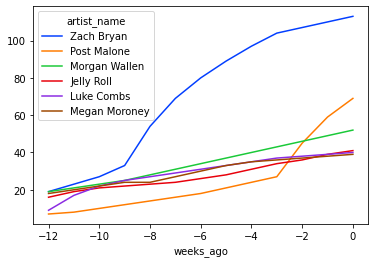

In [46]:
graph = sns.lineplot(
    data = df_artist_ranking.pivot(
        index = 'artist_name'
        , columns = 'weeks_ago'
        , values = 'recent_weeks_main_artist'
      ).loc[
        df_artist_ranking_over_time[0].keys() # maintain order from rank
      ][:6].fillna(np.inf).T
    , dashes = False
    #, markers = ['.'] * n_cols # TODO define new cols
    , palette = 'bright'
)
# title = 'Number of weeks as main artist'
# size = scale up plot size, then scale up number of lines

In [48]:
# Current artist rankings
pd.set_option('display.max_rows', 100)
cols = list(df_artist_ranking.columns)
col_nums = { col:ix for (col,ix) in zip(cols, range(len(cols))) }
df_artist_ranking_compact = df_artist_ranking.rename(columns = col_nums)
df_artist_ranking_compact.loc[ :, 1 : len(cols) - 2 ][df_artist_ranking['weeks_ago'] == 0]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Zach Bryan,0,113,113,113,152,152,152,22,22,22,22,22,22,2.0,2.0,2.0,2.0,2024-05-15
1,Post Malone,0,69,69,69,69,69,69,19,19,19,19,19,19,1.0,1.0,1.0,1.0,2024-05-15
2,Morgan Wallen,0,33,52,64,45,64,76,3,5,6,3,5,6,1.0,1.0,1.0,1.0,2024-05-15
3,Jelly Roll,0,28,41,62,30,58,80,5,7,9,5,7,9,9.0,9.0,9.0,9.0,2024-05-15
4,Luke Combs,0,40,40,48,88,88,96,9,9,11,10,10,12,3.0,3.0,3.0,3.0,2024-05-15
5,Megan Moroney,0,36,39,39,56,63,63,5,6,6,5,6,6,21.0,21.0,21.0,21.0,2024-05-15
6,Koe Wetzel,0,34,34,34,34,34,34,3,3,3,3,3,3,8.0,8.0,8.0,8.0,2024-05-21
7,Bailey Zimmerman,0,31,31,31,37,37,37,4,4,4,4,4,4,7.0,7.0,7.0,7.0,2024-05-15
8,Tucker Wetmore,0,29,29,29,29,29,29,3,3,3,3,3,3,15.0,15.0,15.0,15.0,2024-05-15
9,Dylan Scott,0,19,29,29,27,43,43,2,3,3,2,3,3,35.0,35.0,35.0,35.0,2024-05-15


In [37]:
with duckdb.connect('raw_db.duckdb') as conn:
    print(conn.sql(
        """
        SELECT billboard_observation_date, COUNT(1) n
        FROM raw_db.billboard.billboard_ranking
        GROUP BY 1
        ORDER BY 1 DESC
        """
    ))

┌────────────────────────────┬───────┐
│ billboard_observation_date │   n   │
│            date            │ int64 │
├────────────────────────────┼───────┤
│ 2024-09-10                 │    50 │
│ 2024-09-05                 │    50 │
│ 2024-08-27                 │    50 │
│ 2024-08-23                 │    50 │
│ 2024-08-13                 │    50 │
│ 2024-08-07                 │    50 │
│ 2024-07-31                 │    50 │
│ 2024-07-23                 │    50 │
│ 2024-07-16                 │    50 │
│ 2024-07-10                 │    50 │
│ 2024-07-02                 │    50 │
│ 2024-06-25                 │    50 │
│ 2024-06-18                 │    50 │
│ 2024-06-11                 │    50 │
│ 2024-06-04                 │    50 │
│ 2024-05-29                 │    50 │
│ 2024-05-21                 │    50 │
├────────────────────────────┴───────┤
│ 17 rows                  2 columns │
└────────────────────────────────────┘



In [38]:
# TODO: Set comparison_observation_date as num weeks back, not specific date
current_observation_date = '2024-06-25' # or current_date
comparison_observation_date = '2024-06-18'

with duckdb.connect('raw_db.duckdb') as conn:
    with open('analysis/removed_songs.sql') as sql_file:
        removed_songs = conn.sql(
            sql_file.read().format(
                current_observation_date
                , comparison_observation_date
            )
        )
    print(removed_songs)

┌─────────┬────────────────────────┬────────────────┐
│ song_id │       song_name        │ ranking_before │
│  int32  │        varchar         │     int32      │
├─────────┼────────────────────────┼────────────────┤
│     126 │ Wondering Why          │             23 │
│     127 │ Spin You Around (1/24) │             25 │
│      45 │ Wanna Be Loved         │             41 │
│     128 │ II Most Wanted         │             42 │
│     129 │ Hell Or High Water     │             47 │
│      46 │ Maxed Out              │             49 │
│     130 │ Damn Near Normal       │             50 │
└─────────┴────────────────────────┴────────────────┘



# Scratch work to get song sparklines

In [ ]:
# TODO add a measurement start date column for Friday of each week based on observation date

In [51]:
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

In [49]:
%%sql df_a_song <<
SELECT
    br.billboard_observation_date
    , br.song_id
    , ss.song_name
    , br.billboard_rank
FROM raw_db.billboard.billboard_ranking br
LEFT JOIN raw_db.billboard.song ss
    ON br.song_id = ss.song_id
WHERE br.song_id IN (63, 64) -- # Out Of Oklahoma, Guy For That as examples
ORDER BY 1 ASC
;

In [50]:
df_a_song

,billboard_observation_date,song_id,song_name,billboard_rank
0,2024-07-31,63,Out Of Oklahoma,45
1,2024-08-07,64,Guy For That,7
2,2024-08-07,63,Out Of Oklahoma,43
3,2024-08-13,64,Guy For That,12
4,2024-08-13,63,Out Of Oklahoma,41
5,2024-08-23,64,Guy For That,12
6,2024-08-23,63,Out Of Oklahoma,40
7,2024-08-27,64,Guy For That,7
8,2024-09-05,64,Guy For That,11
9,2024-09-10,64,Guy For That,12


In [51]:
%sql --close duckdb:///C:/Users/Admin/billboard/raw_db.duckdb --quiet

In [52]:
df_a_song.pivot(
        index='billboard_observation_date'
        , columns='song_name'
        , values='billboard_rank'
    ).fillna(np.inf)

song_name,Guy For That,Out Of Oklahoma
billboard_observation_date,,
2024-07-31,inf,45.0
2024-08-07,7.0,43.0
2024-08-13,12.0,41.0
2024-08-23,12.0,40.0
2024-08-27,7.0,inf
2024-09-05,11.0,inf
2024-09-10,12.0,50.0


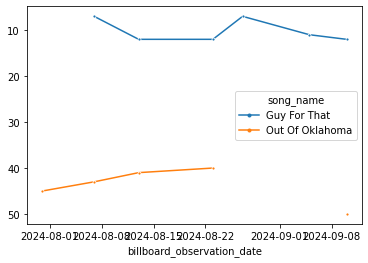

In [53]:
n_lines = 2 # TODO use df.count()

# TODO scale up size
# TODO a line for every song by an artist
# TODO loop through artists
# TODO dash type based on s2a relationship type
graph = sns.lineplot(
    data = df_a_song.pivot(
        index='billboard_observation_date'
        , columns='song_name'
        , values='billboard_rank'
    ).fillna(np.inf) # hide hidden data // TODO: show points with null immediately before and after
    , markers=['.'] * n_lines
    , dashes=False
    # , hue='k' # Not working with error 'cannot be assigned with wide-form data'
)
graph.axes.invert_yaxis()

In [74]:
%%sql df_weeks <<
SELECT
    br.billboard_observation_date
    , br.song_id
    , ss.song_name
    , br.billboard_rank
FROM raw_db.billboard.billboard_ranking br
LEFT JOIN raw_db.billboard.song ss
    ON br.song_id = ss.song_id
ORDER BY 1 ASC

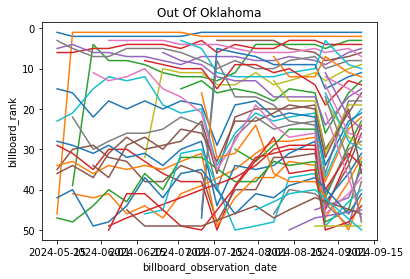

In [111]:
# TODO: Each song on its own tile, rather than overlapped
is_first = True
for _, row in df_weeks.query(
    f"billboard_observation_date == '2024-09-10'"
    # f"billboard_observation_date == '{billboard_observation_date}'"
).sort_values('billboard_rank').iterrows():
    this_song = df_weeks[
        df_weeks['song_id'] == row['song_id']
    ].sort_values('billboard_observation_date').fillna(np.inf)
    
    graph = sns.lineplot(
        data = this_song
        , x = 'billboard_observation_date' # TODO: weeks back instead of obs date
        , y = 'billboard_rank'
        , markers='.' # TODO: fix to show points with null immediately before and after
        , dashes=False
        # , hue='k' # Not working with error 'cannot be assigned with wide-form data'
    ).set_title(this_song.reset_index()['song_name'][0])
    
    if is_first:
        graph.axes.invert_yaxis()
        # TODO: verticalize x-axis labels
        # TODO: Make this about 4x bigger
        is_first = False

'A Bar Song (Tipsy)'